## Notebook to play with convolution for networks

- Setup a binary classification task
- Have peak probabilities for each class
- Then have some shifts also for the class and see if convolution can improve this

In [1]:
import os
import numpy as np
from matplotlib import pylab as plt

import pandas as pd
import math
import random
from sklearn.metrics import roc_auc_score

In [2]:
training_random_ones = None
training_random_zeros = None
test_random_ones = None
test_random_zeros = None

all_ones = None
all_zeros = None

In [3]:
def calculate_number_of_training_set(has_substructure_path):
    global all_ones
    global all_zeros
    substructure = np.loadtxt(has_substructure_path, np.int)
    all_ones = np.where(substructure == 1)
    all_zeros = np.where(substructure == 0)

    number_of_training_set = int(len(all_ones[0]) * 0.7)
    return number_of_training_set

In [4]:
def build_training_and_test_set(num_of_training_set):
    global training_random_ones
    global training_random_zeros
    global test_random_ones
    global test_random_zeros

    training_random_ones = random.sample(list(all_ones[0]), num_of_training_set)
    training_random_zeros = random.sample(list(all_zeros[0]), num_of_training_set)

    test_random_ones = [ones for ones in all_ones[0] if ones not in training_random_ones]
    test_random_zeros = [zeros for zeros in all_zeros[0] if zeros not in training_random_zeros]
    test_random_zeros = random.sample(test_random_zeros, len(test_random_ones))
    
def get_list_of_ids(dataset):
    return ["GNPS_ALL_" + str(index+1) for index in dataset]

Building training and test dataset

In [18]:
filtered_dataset_dir = "G:\\Dev\\Data\\MSMS-NIST\\Python Filtered"

def load_training_spec(spec_path):
    global training_random_ones
    global training_random_zeros
    training_random_ones_id = get_list_of_ids(training_random_ones)
    training_random_zeros_id = get_list_of_ids(training_random_zeros)
    training_set = training_random_ones_id + training_random_zeros_id
    
    file_list = os.listdir(spec_path)
    
    filtered_file_list = [file for file in file_list if file[:-13] in training_set]
    filtered_name_list = [filename[:-13] for filename in filtered_file_list]

    intensities = pd.DataFrame(0.0, index = filtered_name_list, columns=range(1000), dtype=float)

    for file in filtered_file_list:
        filepath = os.path.join(filtered_dataset_dir, file)
        mol_name = file[:-13]
        with open(filepath, 'r') as f:
            for index, line in enumerate(f):
                mass, intensity = line.split(" ")
                if not math.isnan(float(intensity)):
                    intensities.at[mol_name, int(mass)-1] = float(intensity)
    
    return intensities

def load_test_spec(spec_path):
    global test_random_ones
    global test_random_zeros
    test_random_ones_id = get_list_of_ids(test_random_ones)
    test_random_zeros_id = get_list_of_ids(test_random_zeros)
    test_set = test_random_ones_id + test_random_zeros_id
    file_list = os.listdir(spec_path)
    
    filtered_file_list = [file for file in file_list if file[:-13] in test_set]
    filtered_name_list = [filename[:-13] for filename in filtered_file_list]

    test_intensities = pd.DataFrame(0.0, index = filtered_name_list, columns=range(1000), dtype=float)

    for file in filtered_file_list:
        filepath = os.path.join(filtered_dataset_dir, file)
        mol_name = file[:-13]
        with open(filepath, 'r') as f:
            for index, line in enumerate(f):
                mass, intensity = line.split(" ")
                if not math.isnan(float(intensity)):
                    test_intensities.at[mol_name, int(mass)-1] = float(intensity)
    
    return test_intensities

In [6]:
def load_has_substructure(content, intensities):
    has_substructure_truth_values = []
    for index in intensities.index:
        has_substructure_truth_values.append(int(content[int(index.split('_')[2]) - 1][:-1]))
        
    return has_substructure_truth_values

Make a simple keras model to classify this data

In [7]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
def baseline_model(input_to_network):
    class_model = Sequential()
    class_model.add(Dense(50, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(10,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

Using TensorFlow backend.


Following model is a convolutional model for this data

These methods generate spectra that include these shifts and convert the data into the necessary tensor format

- To generate a spectrum, we choose a number of peaks from a Poisson
- We then sample a shift from the class-specific shift distribution
- Sample a starting point
- Sample an intensity for the start and end
- Increment the spectra

In [8]:
def shift_spec_into_tensor(spec_array,shift=[10,20]):
    n_spec,n_bins = spec_array.shape
    spec_tensor = np.zeros((n_spec,n_bins,len(shift)+1),np.double)
    for i in range(n_spec):
        spec = spec_array[i,:]
        shift_spec = np.copy(spec)
        for s in shift:
            shift_spec = np.vstack((shift_spec,np.hstack((spec[s:],np.zeros(s)))))
        spec_tensor[i,:,:] = shift_spec.T
    return spec_tensor[:,:,:,None]

In [9]:
def add_noise(X,n_noise = 5000):
    N,M = X.shape
    for n in range(N):
        X[n,:] += np.random.multinomial(np.random.poisson(n_noise),[1.0/M for m in range(M)])
    return X
def normalise(X):
    for i,row in enumerate(X):
        tot = row.sum()
        if tot > 0:
            for j in range(len(row)):
                X[i,j] = (1.0*row[j])/tot
    return X

- Generate data for the two classes, add some noise and normalise
- Note that `use_shifts` is what the model uses.
- We don't need all the possible shifts to be in `use_shifts` as long as the kernel has sufficient width

In [10]:
from keras.layers import Conv2D,Flatten,MaxPooling2D,AveragePooling2D
def conv_model(n_bins = 1000, n_kernels = 2,kernel_width=1,use_shifts=[15]):
    class_model = Sequential()
    input_shape = (n_bins,len(use_shifts)+1,1)
    n_kernels = n_kernels
    
    pool_width = n_bins - (kernel_width+1)
    pool_size = (pool_width,1)
    
    kernel_size = (kernel_width,len(use_shifts)+1)
    class_model.add(Conv2D(n_kernels, input_shape=input_shape, 
                           kernel_initializer='normal', activation='relu',strides=1,
                          kernel_size = kernel_size))

#     class_model.add(AveragePooling2D(pool_size = pool_size))
    class_model.add(MaxPooling2D(pool_size = pool_size))
    class_model.add(Flatten())
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model


Second model for comparison

In [11]:
def calc_peak_differences(spec):
    non_zero_peaks = list(np.where(spec>0)[0])
    peak_differences = [(abs(i-j), (spec[i]+spec[j]/2.0)) for i in non_zero_peaks for j in non_zero_peaks if i != j and j > i]
    
    return peak_differences

In [12]:
def load_shift_bins(intensities):
    shift_bins = np.zeros(intensities.shape, np.double)

    for index, spec in enumerate(intensities.values):
        peak_differences = calc_peak_differences(spec)
        for shift, average_intensity in peak_differences:
            shift_bins[index, shift - 1] += average_intensity

    return shift_bins

In [22]:
def train_conv_diff_splits(path, name, has_substruct_dataset, shift, splits=10):
    global filtered_dataset_dir
    global training_random_ones
    global training_random_zeros
    global test_random_ones
    global test_random_zeros
    epochs = 200
    extra_epochs = 100
    path = path + name
    n_kernels = 3
    kernel_width = 5
    truth_values = []
    test_truth_values = []

    with open(has_substruct_dataset, 'r') as f:
        content = f.readlines()

    with open(path, 'w') as f:
        for i in range(splits):
            number_of_training_set = calculate_number_of_training_set(has_substruct_dataset)
            build_training_and_test_set(number_of_training_set)

            training_random_ones_id = get_list_of_ids(training_random_ones)
            training_random_zeros_id = get_list_of_ids(training_random_zeros)
            training_set = training_random_ones_id + training_random_zeros_id

            test_random_ones_id = get_list_of_ids(test_random_ones)
            test_random_zeros_id = get_list_of_ids(test_random_zeros)
            test_set = test_random_ones_id + test_random_zeros_id
            
            intensities = load_training_spec(filtered_dataset_dir)
            intensities = intensities.reindex(index=intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

            test_intensities = load_test_spec(filtered_dataset_dir)
            test_intensities = test_intensities.reindex(index=test_intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

            truth_values = load_has_substructure(content, intensities)
            test_truth_values = load_has_substructure(content, test_intensities)
            
            X = intensities.values
            N,M = X.shape
            shuffle_order = np.random.permutation(N)
            labels = truth_values
            labels = np.array(labels)[:,None]
            test_labels = test_truth_values
            test_labels = np.array(test_labels)[:,None]
            
            use_shifts = np.asarray([shift])

            X_tensor = shift_spec_into_tensor(X,shift=use_shifts)
            print(X_tensor.shape)
            
            mod = conv_model(n_kernels = n_kernels, kernel_width=kernel_width, use_shifts=use_shifts)
            mod.fit(X_tensor[shuffle_order,:,:],labels[shuffle_order],epochs=epochs,validation_split=0.2,verbose=0)
            
            test_tensor = shift_spec_into_tensor(test_intensities.values,shift=use_shifts)
            predicted = mod.predict(test_tensor)
            
            auc = roc_auc_score(test_labels, predicted)
            f.write(str(auc) + "\n")
        
def train_shifts_diff_splits(path, name, has_substruct_dataset, splits=10):
    global filtered_dataset_dir
    global training_random_ones
    global training_random_zeros
    global test_random_ones
    global test_random_zeros
    epochs = 200
    extra_epochs = 100
    path = path + name
    truth_values = []
    test_truth_values = []

    with open(has_substruct_dataset, 'r') as f:
        content = f.readlines()

    with open(path, 'w') as f:
        for i in range(splits):
            number_of_training_set = calculate_number_of_training_set(has_substruct_dataset)
            build_training_and_test_set(number_of_training_set)

            training_random_ones_id = get_list_of_ids(training_random_ones)
            training_random_zeros_id = get_list_of_ids(training_random_zeros)
            training_set = training_random_ones_id + training_random_zeros_id

            test_random_ones_id = get_list_of_ids(test_random_ones)
            test_random_zeros_id = get_list_of_ids(test_random_zeros)
            test_set = test_random_ones_id + test_random_zeros_id

            intensities = load_training_spec(filtered_dataset_dir)
            intensities = intensities.reindex(index=intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)
           
            test_intensities = load_test_spec(filtered_dataset_dir)
            test_intensities = test_intensities.reindex(index=test_intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

            truth_values = load_has_substructure(content, intensities)
            test_truth_values = load_has_substructure(content, test_intensities)

            X = intensities.values
            N,M = X.shape
            shuffle_order = np.random.permutation(N)
            labels = truth_values
            labels = np.array(labels)[:,None]
            test_labels = test_truth_values
            test_labels = np.array(test_labels)[:,None]

            shift_bins = load_shift_bins(intensities)

            X_shifts = normalise(shift_bins)
            print(X_shifts.shape)

            mod = baseline_model(X_shifts)
            mod.fit(X_shifts[shuffle_order,:],labels[shuffle_order],epochs=extra_epochs,validation_split=0.2,verbose=0)

            test_shift_bins = load_shift_bins(test_intensities)
            X_test_shifts = normalise(test_shift_bins)
            print(X_test_shifts.shape)

            predicted = mod.predict(X_test_shifts)

            auc = roc_auc_score(test_labels, predicted)
            f.write(str(auc) + "\n")

In [18]:
amino_acid_path = "G:\\Dev\\Data\\Fragment Masses.txt"
amino_acids_with_shifts = []

with open(amino_acid_path, 'r') as f:
    for line in f:
        amino_acid, shift = line.split(", ")
        amino_acids_with_shifts.append((amino_acid, int(float(shift[:-1]))))

print(amino_acids_with_shifts)

[('Alanine', 71), ('Arginine', 156), ('Asparagine', 114), ('Aspartic Acid', 115), ('Cysteine', 103), ('Glutamic Acid', 129), ('Glutamine', 128), ('Glycine', 57), ('Histidine', 137), ('Isoleucine', 113), ('Leucine', 113), ('Lysine', 128), ('Methionine', 131), ('Phenylalanine', 147), ('Proline', 97), ('Serine', 87), ('Threonine', 101), ('Tryptophan', 186), ('Tyrosine', 163), ('Valine', 99)]


In [25]:
processed_amino_acid = ["Alanine", "Arginine", "Glutamine", "Asparagine", "Aspartic Acid", "Cysteine", "Glutamic Acid", 
                        "Glycine", "Histidine", "Isoleucine", "Leucine"]
missing_amino_acid = "Glutamine"
path = "G:\\Dev\\Data\\Convolution vs Dense Experiments corrected\\"

for amino_acid, shift in amino_acids_with_shifts:
    if amino_acid != missing_amino_acid and amino_acid not in processed_amino_acid:
        dataset = "G:\\Dev\\Data\\NIST Amino Acids\\NIST {} Has Substructure.txt".format(amino_acid)
        train_shifts_diff_splits(path, "Shifts {} AUC.txt".format(amino_acid), dataset)
        train_conv_diff_splits(path, "Conv {} AUC.txt".format(amino_acid), dataset, shift, splits=10)

(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000)
(1260, 1000)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(2934, 1000, 2, 1)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000)
(324, 1000)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(750, 1000, 2, 1)
(764, 1000)
(330, 1000)
(764, 1000)
(330, 1000)
(764, 1000)
(330, 1000)
(764, 1000)
(330, 1000)
(764, 1000)
(330, 1000)
(764, 1000

In [11]:
path = "G:\\Dev\\Data\\Convolution vs Dense Experiments corrected\\"
df_shifts = pd.read_csv(path + "Shifts Alanine AUC.txt", header=None)
df_conv = pd.read_csv(path + "Conv Alanine AUC.txt", header=None)
df_combined = pd.concat([df_shifts, df_conv], axis=1)
df_combined.columns = ["Shifts", "Conv"]

Index(['Shifts', 'Conv'], dtype='object')
          0
0  0.852761
1  0.820384
2  0.821391
3  0.899595
4  0.844519
5  0.840184
6  0.890185
7  0.903554
8  0.848412
9  0.888131
          0
0  0.714301
1  0.588177
2  0.669562
3  0.677857
4  0.663588
5  0.691817
6  0.653387
7  0.689710
8  0.677173
9  0.560512
     Shifts      Conv
0  0.852761  0.714301
1  0.820384  0.588177
2  0.821391  0.669562
3  0.899595  0.677857
4  0.844519  0.663588
5  0.840184  0.691817
6  0.890185  0.653387
7  0.903554  0.689710
8  0.848412  0.677173
9  0.888131  0.560512


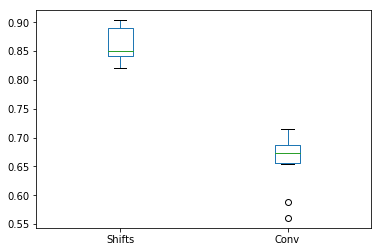

In [13]:
from scipy import stats
import matplotlib.pyplot as plt

df_combined[['Shifts', 'Conv']].plot(kind='box')

In [16]:
stats.ttest_rel(df_combined['Shifts'], df_combined['Conv'])

Ttest_relResult(statistic=11.221065799556373, pvalue=1.360958273920665e-06)

In [19]:
path = "G:\\Dev\\Data\\Convolution vs Dense Experiments corrected\\"
missing_amino_acid = "Glutamine"

for amino_acid, shift in amino_acids_with_shifts:
    if amino_acid != missing_amino_acid:        
        df_shifts = pd.read_csv(path + "Shifts {} AUC.txt".format(amino_acid), header=None)
        df_conv = pd.read_csv(path + "Conv {} AUC.txt".format(amino_acid), header=None)
        df_combined = pd.concat([df_shifts, df_conv], axis=1)
        df_combined.columns = ["Shifts", "Conv"]
        t_test = stats.ttest_rel(df_combined['Shifts'], df_combined['Conv'])
        print(amino_acid + ": " + str(t_test))

Alanine: Ttest_relResult(statistic=11.221065799556373, pvalue=1.360958273920665e-06)
Arginine: Ttest_relResult(statistic=28.5750086111355, pvalue=3.8328019853930337e-10)
Asparagine: Ttest_relResult(statistic=16.725438280769435, pvalue=4.36717980880867e-08)
Aspartic Acid: Ttest_relResult(statistic=10.596471853565722, pvalue=2.20475016639447e-06)
Cysteine: Ttest_relResult(statistic=20.999878665699455, pvalue=5.902295392507168e-09)
Glutamic Acid: Ttest_relResult(statistic=16.11574726396528, pvalue=6.04057600384934e-08)
Glycine: Ttest_relResult(statistic=21.29469907408046, pvalue=5.21802415846084e-09)
Histidine: Ttest_relResult(statistic=24.686189478071988, pvalue=1.4084292165671842e-09)
Isoleucine: Ttest_relResult(statistic=22.404763799156985, pvalue=3.3283701743627767e-09)
Leucine: Ttest_relResult(statistic=23.173613772424893, pvalue=2.468281924435496e-09)
Lysine: Ttest_relResult(statistic=17.375865382206925, pvalue=3.127198069649469e-08)
Methionine: Ttest_relResult(statistic=15.32781732